<a href="https://colab.research.google.com/github/Codertweet/Twitter-Sentiment-Analysis---TFIDF/blob/main/Tsa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [175]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer

import re
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [176]:
data = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None)

data.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [177]:
data.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
data.head()


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [178]:
print("Number of rows:", data.shape[0])
print("Number of columns:", data.shape[1])

Number of rows: 1600000
Number of columns: 6


In [179]:
encoding_used = "ISO-8859-1"

In [180]:
data.drop('flag', axis=1, inplace=True)

data.head()

,target,ids,date,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [181]:
print(f'The dataset has {data.isna().sum().sum()} missing values.')
print(f'The dataset has {data.duplicated().sum()} duplicate entries.')

The dataset has 0 missing values.
The dataset has 0 duplicate entries.


In [182]:
data.dtypes

,0
target,int64
ids,int64
date,object
user,object
text,object


In [183]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

stopwordlist =  stopwords.words('english')

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
#tweets_data = pd.read_csv(data, encoding = encoding_used, names = data.columns )data.head()

In [184]:
data.head()

,target,ids,date,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


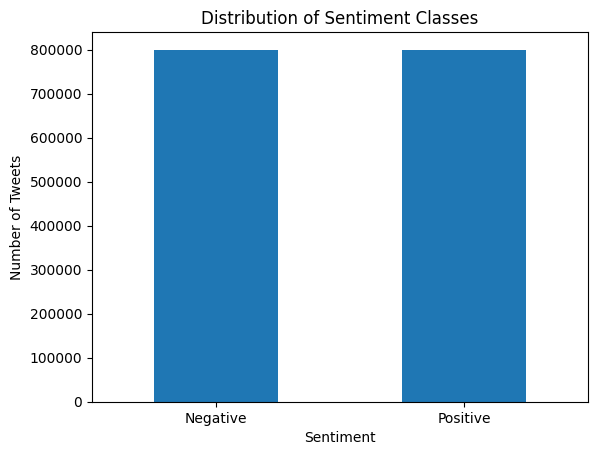

In [185]:
target_group = data['target'].value_counts().sort_index()
ax = target_group.plot(kind='bar', title='Distribution of Sentiment Classes', legend=False)
ax.set_xticklabels(['Negative', 'Positive'], rotation=0)
ax.set_xlabel('Sentiment')
ax.set_ylabel('Number of Tweets')
plt.show()

In [186]:
print(f'The dataset has {data.isna().sum().sum()} missing values.')
print(f'The dataset has {data.duplicated().sum()} duplicate entries.')

The dataset has 0 missing values.
The dataset has 0 duplicate entries.


In [187]:
data['date'] = pd.to_datetime(data['date'])

data['month'] = data['date'].dt.month_name()
data['year'] = data['date'].dt.year

data.head()

,target,ids,date,user,text,month,year
0,0,1467810369,2009-04-06 22:19:45,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",April,2009
1,0,1467810672,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,April,2009
2,0,1467810917,2009-04-06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,April,2009
3,0,1467811184,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire,April,2009
4,0,1467811193,2009-04-06 22:19:57,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",April,2009


In [188]:
print(f'The data spans the year(s) {data.year.unique()[0]} and the month(s) {list(data.month.unique())}.')

The data spans the year(s) 2009 and the month(s) ['April', 'May', 'June'].


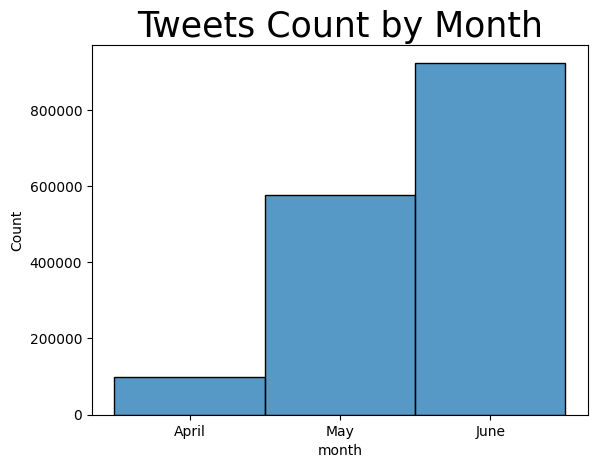

In [189]:
sns.histplot(data.month)

plt.title('Tweets Count by Month', size=25);

In [190]:
print(f'There are {data.ids.nunique()} unique tweet IDs and {len(data)} rows in the dataset.')
print(f'The ratio between them is {data.ids.nunique() / len(data):.3f}.')

There are 1598315 unique tweet IDs and 1600000 rows in the dataset.
The ratio between them is 0.999.


In [191]:
print(f'There are {data.user.nunique()} unique users. They wrote {len(data)} tweets in total.')

There are 659775 unique users. They wrote 1600000 tweets in total.


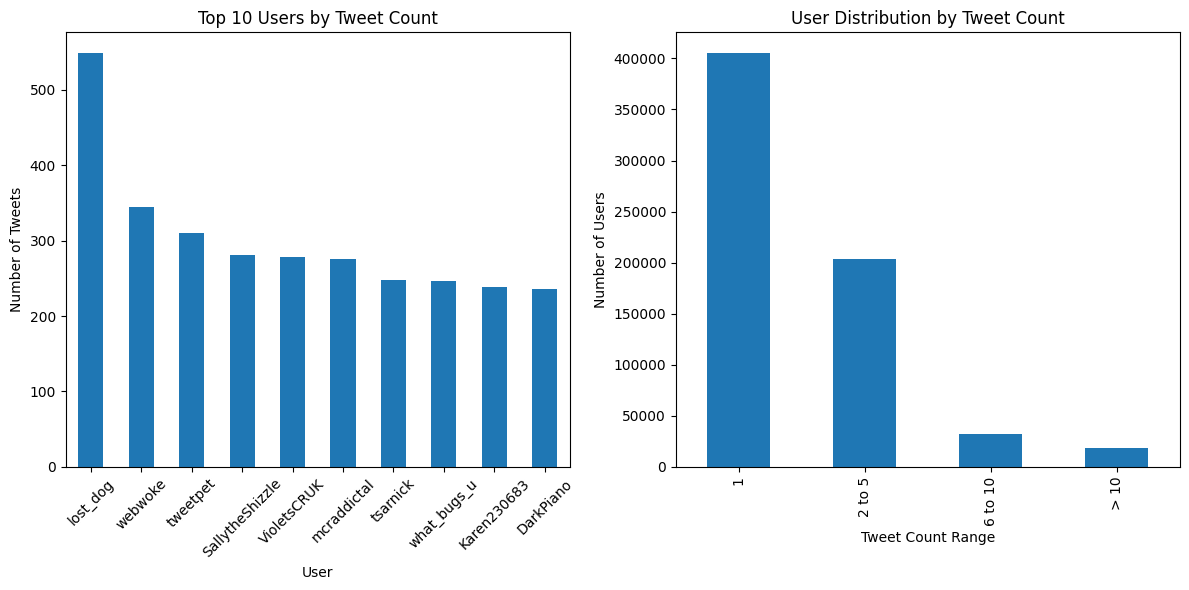

In [192]:

# Step 1: Count tweets per user
tweet_user_count = data['user'].value_counts().reset_index()
tweet_user_count.columns = ['user', 'count']  # Rename columns

# Step 2: Get top 10 users with most tweets
top_10_tweeters = tweet_user_count.sort_values(by='count', ascending=False).head(10)

# Step 3: Categorize tweet counts into bins
tweet_user_count['number of tweets'] = pd.cut(tweet_user_count['count'],
                                              bins=[0, 1, 5, 10, 1000],
                                              labels=['1', '2 to 5', '6 to 10', '> 10'])

# Step 4: Plotting
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

# Left plot: Top 10 tweeters
top_10_tweeters.plot(kind='bar', x='user', y='count', ax=ax1, legend=False)
ax1.set_title('Top 10 Users by Tweet Count')
ax1.set_xlabel('User')
ax1.set_ylabel('Number of Tweets')
ax1.tick_params(axis='x', rotation=45)

# Right plot: Distribution of users by tweet count ranges
tweet_user_count['number of tweets'].value_counts().sort_index().plot(kind='bar', ax=ax2)
ax2.set_title('User Distribution by Tweet Count')
ax2.set_xlabel('Tweet Count Range')
ax2.set_ylabel('Number of Users')

plt.tight_layout()
plt.show()


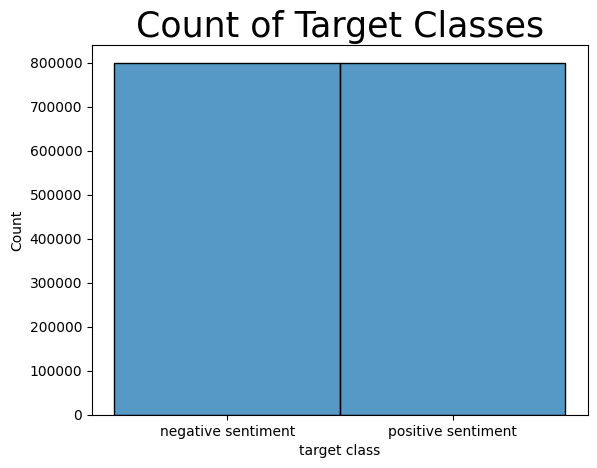

In [193]:
data.loc[data.target == 4, 'target'] = 1

data.loc[data.target == 0, 'target class'] = 'negative sentiment'
data.loc[data.target == 1, 'target class'] = 'positive sentiment'

sns.histplot(data['target class'])
plt.title('Count of Target Classes', size=25);

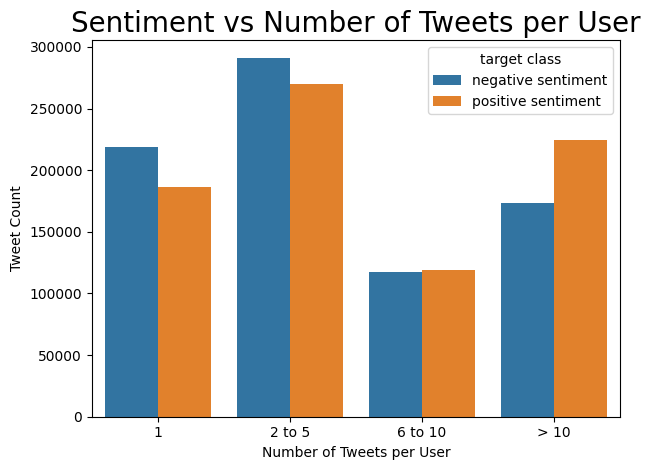

In [194]:
# Count of tweets by user and target class
user_count_target_class = data.groupby(['user', 'target class']).size().reset_index(name='count')

# Merge with tweet_user_count to get number of tweets per user category
user_count_target_class = user_count_target_class.merge(
    tweet_user_count[['user', 'number of tweets']], on='user'
)

# Aggregate sentiment count by tweet range and sentiment
target_class_sentiment = user_count_target_class.groupby(['number of tweets', 'target class'])['count'].sum().reset_index()

# Plot
sns.barplot(data=target_class_sentiment, x='number of tweets', y='count', hue='target class')
plt.title('Sentiment vs Number of Tweets per User', size=20)
plt.xlabel('Number of Tweets per User')
plt.ylabel('Tweet Count')
plt.tight_layout()
plt.show()


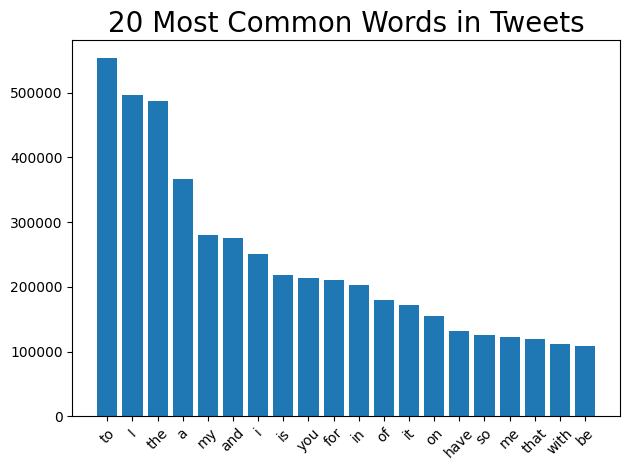

In [195]:
most_common_words = Counter(" ".join(data["text"]).split()).most_common(20)

x,y = zip(*most_common_words)

plt.bar(x, y)
plt.xticks(rotation=45)
plt.title("20 Most Common Words in Tweets",size=20)

plt.tight_layout()
plt.show()

In [196]:
data.drop(['ids','date','user','month','year','target class'], axis=1, inplace=True)

In [197]:
def filter_text(text):

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove punctuation and special characters
    text = re.sub('[^a-zA-z]', ' ', text)
    # Convert text into lower case
    text = text.lower()

    return text


data['text'] = data['text'].apply(filter_text)

data.head()

,target,text
0,0,switchfoot awww that s a bummer you shoulda got david carr of third day to do it d
1,0,is upset that he can t update his facebook by texting it and might cry as a result school today also blah
2,0,kenichan i dived many times for the ball managed to save the rest go out of bounds
3,0,my whole body feels itchy and like its on fire
4,0,nationwideclass no it s not behaving at all i m mad why am i here because i can t see you all over there


In [209]:
X = data['text']
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1120000,), (480000,), (1120000,), (480000,))

In [210]:
featurizer = TfidfVectorizer()

X_train2 = featurizer.fit_transform(X_train)
X_test2  = featurizer.transform(X_test)

In [211]:
def get_test_scores(model_name:str,preds,y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy  = accuracy_score(y_test_data,preds)
    precision = precision_score(y_test_data,preds,average='macro')
    recall    = recall_score(y_test_data,preds,average='macro')
    f1        = f1_score(y_test_data,preds,average='macro')

    table = pd.DataFrame({'model': [model_name],'precision': [precision],'recall': [recall],
                          'F1': [f1],'accuracy': [accuracy]})

    return table

In [212]:
MNB = MultinomialNB()
MNB.fit(X_train2, y_train)

MNB_train_preds   = MNB.predict(X_train2)
MNB_train_results = get_test_scores('MNB (train)', MNB_train_preds, y_train)

MNB_test_preds   = MNB.predict(X_test2)
MNB_test_results = get_test_scores('MNB (test)', MNB_test_preds, y_test)

MNB_results = pd.concat([MNB_train_results,MNB_test_results], axis=0)
MNB_results

,model,precision,recall,F1,accuracy
0,MNB (train),0.837276,0.835548,0.835371,0.835588
0,MNB (test),0.774545,0.772504,0.771989,0.772388


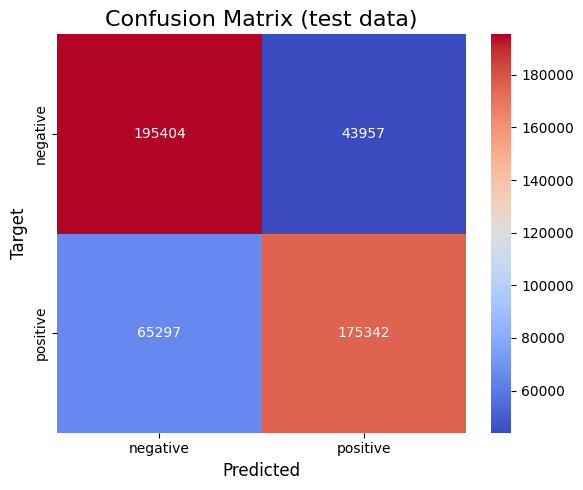

In [219]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, MNB_test_preds, labels=MNB.classes_)

# Plot with a different color map (e.g., "coolwarm", "coolwarm", "viridis")
plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm, annot=True, cmap="coolwarm", fmt='d', cbar=True)

ax.set_title('Confusion Matrix (test data)', fontsize=16)
ax.xaxis.set_ticklabels(['negative','positive'], fontsize=10)
ax.yaxis.set_ticklabels(['negative','positive'], fontsize=10)
ax.set_xlabel("Predicted", fontsize=12)
ax.set_ylabel("Target", fontsize=12)

plt.tight_layout()